# Préparation du Dataset IAM pour Text-to-Handwritten

Ce notebook couvre les premières étapes pour préparer le dataset IAM Handwriting Database, avec tout le prétraitement nécessaire.
Assumptions :
- Vous avez extrait les archives .tgz dans un dossier racine (ex. : 'C:\\Users\\Hp\\Desktop\\GEN AI\\IAM_dataset').
- Chemins : ascii/, lines/, words/, xml/ sont dans ce dossier.

Pré-traitement complet :
1. Vérification des chemins et existence des fichiers.
2. Chargement des transcriptions avec gestion d'encodage et filtrage.
3. Chargement et prétraitement des images (grayscale, resize, normalisation).
4. Création de paires (texte, image) avec validation.
5. Ajout de métadonnées XML (ex. writer ID).
6. Création de splits train/test/val.
7. Augmentation de données basique (optionnel : flip, rotation pour varier les images).
8. Sauvegarde des données prétraitées.

Exécutez les cellules dans l'ordre. Adaptez les chemins si nécessaire.

In [11]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ----------                               0.4/1.6 MB 14.5 kB/s eta 0:01:22


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\Desktop\GEN AI\py310env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\Hp\Desktop\GEN AI\py310env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hp\Desktop\GEN AI\py310env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\ssl.py", lin

In [3]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     --------------------------------------- 11.3/11.3 MB 24.3 MB/s eta 0:00:00
     ---------------------------------------- 509.2/509.2 kB ? eta 0:00:00
     -------------------------------------- 347.8/347.8 kB 7.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 8.1/8.1 MB 4.6 MB/s eta 0:00:00
     -------------------------------------- 225.2/225.2 kB 6.9 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 6.9 MB/s eta 0:00:00
     ---------------------------------------- 73.8/73.8 kB ? eta 0:00:00
     ---------------------------------------- 113.9/113.9 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Imports nécessaires
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET  # Pour parser XML
from torchvision import transforms  # Pour augmentation optionnelle

# Définir le dossier racine du dataset (adaptez ce chemin à votre cas)
ROOT_DIR = r'C:\Users\Hp\Desktop\GEN AI\IAM_dataset'  # Utilisez des raw strings avec r pour Windows

# Chemins spécifiques
ascii_dir = os.path.join(ROOT_DIR, 'ascii')
ascii_lines_txt = os.path.join(ascii_dir, 'lines.txt')
ascii_words_txt = os.path.join(ascii_dir, 'words.txt')
lines_dir = os.path.join(ROOT_DIR, 'lines')
words_dir = os.path.join(ROOT_DIR, 'words')
xml_dir = os.path.join(ROOT_DIR, 'xml')

# Chemins pour splits (IAM en a des prédéfinis)
split_dir = os.path.join(ascii_dir, 'largeWriterIndependentTextLineRecognitionTask')

# Vérification des chemins
print(f'ASCII dir: {ascii_dir}')
print(f'Lines dir: {lines_dir}')
print(f'XML dir: {xml_dir}')
if not os.path.exists(ascii_lines_txt):
    print(f'Erreur : lines.txt non trouvé à {ascii_lines_txt}')
if not os.path.exists(lines_dir):
    print(f'Erreur : dossier lines/ non trouvé à {lines_dir}')

ASCII dir: C:\Users\Hp\Desktop\GEN AI\IAM_dataset\ascii
Lines dir: C:\Users\Hp\Desktop\GEN AI\IAM_dataset\lines
XML dir: C:\Users\Hp\Desktop\GEN AI\IAM_dataset\xml


## Étape 1 : Chargement des transcriptions pour lines (de ascii/lines.txt)

Pré-traitement : Gestion d'encodage, filtrage des erreurs, nettoyage des transcriptions.

In [7]:
def load_ascii_transcriptions(file_path, is_words=False):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                if not line.startswith('#'):
                    parts = line.strip().split(' ')
                    item_id = parts[0]
                    result = parts[1]
                    if result != 'err':
                        start_idx = 8
                        transcription = ' '.join(parts[start_idx:]).replace('|', ' ').strip()
                        transcription = ' '.join(transcription.split())  # Supprimer espaces multiples
                        if transcription:
                            data.append({'id': item_id, 'text': transcription})
    except UnicodeDecodeError:
        print(f'Erreur d\'encodage pour {file_path}. Essayez avec un autre encodage.')
        return pd.DataFrame(data)
    return pd.DataFrame(data)

# Chargement pour lines
df_lines = load_ascii_transcriptions(ascii_lines_txt, is_words=False)
print(f'Nombre de lignes chargées : {len(df_lines)}')
if len(df_lines) == 0:
    print('Aucune donnée chargée. Vérifiez le fichier lines.txt.')
else:
    df_lines.head()

Nombre de lignes chargées : 11344


## Étape 2 : Chargement des transcriptions pour words (optionnel)

In [8]:
# Chargement pour words
df_words = load_ascii_transcriptions(ascii_words_txt, is_words=True)
print(f'Nombre de mots chargés : {len(df_words)}')
if len(df_words) == 0:
    print('Aucune donnée chargée pour words. Vérifiez le fichier words.txt.')
else:
    df_words.head()

Nombre de mots chargés : 96456


## Étape 3 : Fonctions pour charger et prétraiter les images

Pré-traitement : Grayscale, resize, normalisation, augmentation optionnelle (flip, rotation).

In [9]:
# Augmentation optionnelle
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),  # Légère rotation pour varier
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

def load_image(item_id, img_dir, is_word=False, apply_augment=False):
    parts = item_id.split('-')
    folder1 = parts[0]
    folder2 = '-'.join(parts[:2])
    img_path = os.path.join(img_dir, folder1, folder2, f'{item_id}.png')
    
    if os.path.exists(img_path):
        if os.path.getsize(img_path) == 0:
            print(f'Image file is empty: {img_path}')
            return None
        try:
            img = Image.open(img_path).convert('L')
            target_height = 32 if is_word else 64
            width = int(img.width * (target_height / img.height)) if img.height > 0 else 0
            img = img.resize((max(width, 1), target_height))
            if apply_augment:
                img = augment(img)
            else:
                img = np.array(img) / 255.0
            return img
        except Exception as e:
            print(f'Erreur lors du chargement de {img_path}: {e}')
            return None
    else:
        print(f'Image non trouvée : {img_path}')
        return None

## Étape 4 : Création des paires pour lines avec prétraitement

In [11]:
pairs_lines = []
for idx, row in df_lines.iterrows():
    img = load_image(row['id'], lines_dir, is_word=False, apply_augment=True)  # Avec augmentation
    if img is not None:
        pairs_lines.append({'id': row['id'], 'text': row['text'], 'image': img})

print(f'Nombre de paires lines valides : {len(pairs_lines)}')
if len(pairs_lines) == 0:
    print('Aucune paire créée. Vérifiez les images dans lines/.')

Nombre de paires lines valides : 11344


## Étape 5 : Création des paires pour words (optionnel)

In [13]:
# Explication : Le message d'erreur precedent indiquait que des fichiers images sont vides (taille 0).
# Le code est modifie pour ignorer ces fichiers et continuer le traitement, 
# tout en comptant le nombre de fichiers ignores pour information.

def load_image_silent(item_id, img_dir, is_word=False, apply_augment=False):
    parts = item_id.split('-')
    folder1 = parts[0]
    folder2 = '-'.join(parts[:2])
    img_path = os.path.join(img_dir, folder1, folder2, f'{item_id}.png')
    
    if os.path.exists(img_path):
        if os.path.getsize(img_path) == 0:
            return None
        try:
            img = Image.open(img_path).convert('L')
            target_height = 32 if is_word else 64
            width = int(img.width * (target_height / img.height)) if img.height > 0 else 0
            img = img.resize((max(width, 1), target_height))
            if apply_augment:
                img = augment(img)
            else:
                img = np.array(img) / 255.0
            return img
        except Exception as e:
            return None
    else:
        return None

pairs_words = []
skipped_files = 0
for idx, row in df_words.iterrows():
    img = load_image_silent(row['id'], words_dir, is_word=True, apply_augment=True)
    if img is not None:
        pairs_words.append({'id': row['id'], 'text': row['text'], 'image': img})
    else:
        skipped_files += 1

print(f'Nombre de paires words valides : {len(pairs_words)}')
if skipped_files > 0:
    print(f'Nombre de fichiers images ignorés : {skipped_files}')

if len(pairs_words) == 0:
    print('Aucune paire créée pour words. Vérifiez les images dans words/.')

Nombre de paires words valides : 96454
Nombre de fichiers images ignorés : 2


## Étape 6 : Visualisation d'exemples (pour lines)

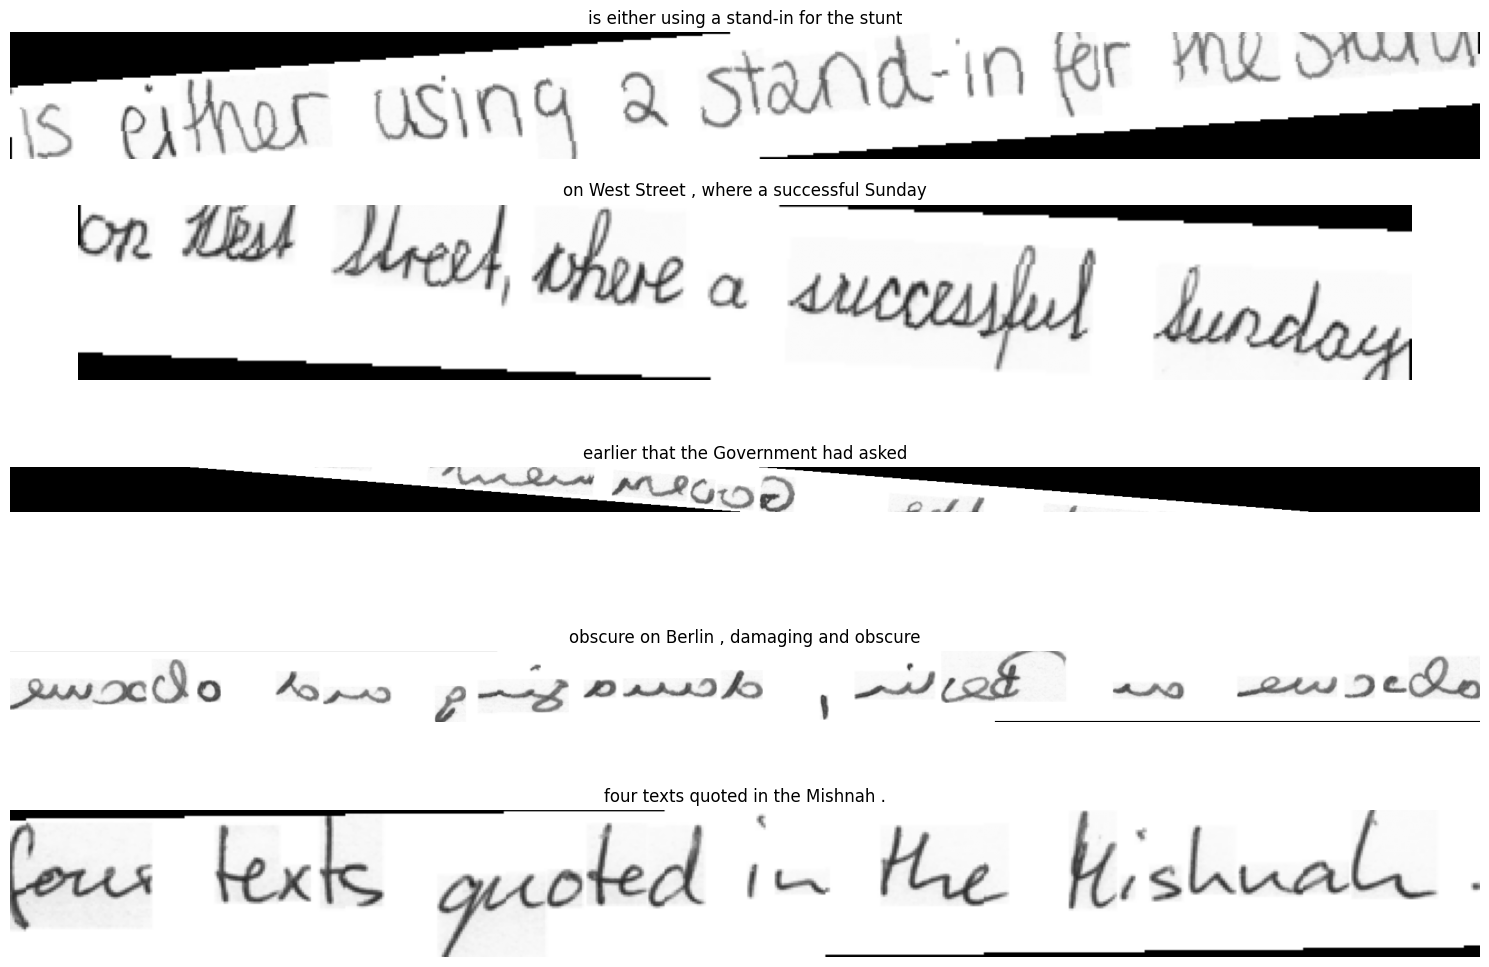

In [8]:
# Afficher 5 exemples aléatoires de lines
num_examples = 5
if len(pairs_lines) >= num_examples:
    indices = np.random.choice(len(pairs_lines), num_examples, replace=False)
    fig, axs = plt.subplots(num_examples, 1, figsize=(15, num_examples * 2))
    for i, idx in enumerate(indices):
        pair = pairs_lines[idx]
        axs[i].imshow(np.squeeze(pair['image']), cmap='gray')
        axs[i].set_title(pair['text'])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f'Pas assez de paires ({len(pairs_lines)}) pour visualiser {num_examples} exemples.')

## Étape 8 : Création des splits train/test/val

Pré-traitement : Utilisation des splits prédéfinis pour éviter overfitting.

In [14]:
print(f"Nombre de paires lines : {len(pairs_lines)}")
print(f"Nombre de paires words : {len(pairs_words)}")
if pairs_lines:
    print(f"Exemple de paire lines : {pairs_lines[0]}")
if pairs_words:
    print(f"Exemple de paire words : {pairs_words[0]}")

Nombre de paires lines : 11344
Nombre de paires words : 96454
Exemple de paire lines : {'id': 'a01-000u-00', 'text': 'A MOVE to stop Mr. Gaitskell from', 'image': tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.8745,  0.9373, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.8667,  0.9216, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.8353,  0.9059, -1.0000],
         ...,
         [-1.0000,  0.8902,  0.3176,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.8824,  0.3961,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.8588,  0.4824,  ..., -1.0000, -1.0000, -1.0000]]])}
Exemple de paire words : {'id': 'a01-000u-00-00', 'text': 'A', 'image': tensor([[[ 0.9686,  0.8588,  0.1843, -0.3412, -0.1686,  0.6235,  0.9294,
           0.9373,  0.9529,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,
           0.9686,  0.9686],
         [ 0.9451,  0.5922, -0.3176, -0.4902, -0.4824, -0.0510,  0.8431,
           0.9529,  0.9529,  0.9686,  0.9686,  0.9686,  0.9608,  0.9686,
 

In [15]:
from sklearn.model_selection import train_test_split

# Supposons que df_lines contient toutes les lignes valides
train_val, df_test = train_test_split(df_lines, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(train_val, test_size=0.1111, random_state=42)  # 0.1/0.9 ≈ 0.1111

print(f'Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}')

# Mettre à jour les paires si nécessaire (optionnel, selon votre workflow)
# Par exemple, filtrez pairs_lines avec df_train['id'], etc.

Train: 9074, Val: 1135, Test: 1135


In [16]:
import os
print(os.path.exists('iam_lines_pairs.npz'))

True


In [17]:
np.savez('iam_words_pairs.npz', pairs=pairs_words)
np.savez('iam_lines_pairs.npz', pairs=pairs_lines)

In [18]:
# Vérification des paires
print(f"Nombre de paires lines : {len(pairs_lines)}")
print(f"Nombre de paires words : {len(pairs_words)}")
if pairs_lines:
    print(f"Exemple de paire lines : {pairs_lines[0]}")

# Sauvegarde si nécessaire
np.savez('iam_lines_pairs.npz', pairs=pairs_lines)
print("Paires lines sauvegardées dans iam_lines_pairs.npz")

# Création de splits manuels (optionnel)
from sklearn.model_selection import train_test_split
if len(df_lines) > 0:
    train_val, df_test = train_test_split(df_lines, test_size=0.1, random_state=42)
    df_train, df_val = train_test_split(train_val, test_size=0.1111, random_state=42)
    print(f'Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}')
    # Sauvegarde des splits
    df_train.to_csv('iam_train.csv', index=False)
    df_val.to_csv('iam_val.csv', index=False)
    df_test.to_csv('iam_test.csv', index=False)
    print("Splits manuels sauvegardés.")
else:
    print("Aucune donnée dans df_lines pour créer des splits.")

Nombre de paires lines : 11344
Nombre de paires words : 96454
Exemple de paire lines : {'id': 'a01-000u-00', 'text': 'A MOVE to stop Mr. Gaitskell from', 'image': tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.8745,  0.9373, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.8667,  0.9216, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.8353,  0.9059, -1.0000],
         ...,
         [-1.0000,  0.8902,  0.3176,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.8824,  0.3961,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.8588,  0.4824,  ..., -1.0000, -1.0000, -1.0000]]])}
Paires lines sauvegardées dans iam_lines_pairs.npz
Train: 9074, Val: 1135, Test: 1135
Splits manuels sauvegardés.


## Étape 9 : Sauvegarde des données prétraitées

In [19]:
# Sauvegarde pour lines
np.savez('iam_lines_pairs.npz', pairs=pairs_lines)

# Pour words
np.savez('iam_words_pairs.npz', pairs=pairs_words)

# Export transcriptions en CSV
df_lines.to_csv('iam_lines_transcriptions.csv', index=False)
df_train.to_csv('iam_train.csv', index=False)
df_val.to_csv('iam_val.csv', index=False)
df_test.to_csv('iam_test.csv', index=False)

print('Toutes les données prétraitées et sauvegardées.')

Toutes les données prétraitées et sauvegardées.


## Étapes suivantes

- Utilisez ces paires pour l'entraînement dans un autre notebook.
- Si erreurs : Vérifiez les chemins, encodage, ou IDs.